<a href="https://colab.research.google.com/github/collen1/Trade/blob/main/trade_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model loaded.
2025-08-05T16:51:25.688383 - ✅ Model loaded (version: 1754162454.0)


/tmp/ipython-input-608795949.py:476: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = FuncAnimation(self.fig, update, interval=1000)


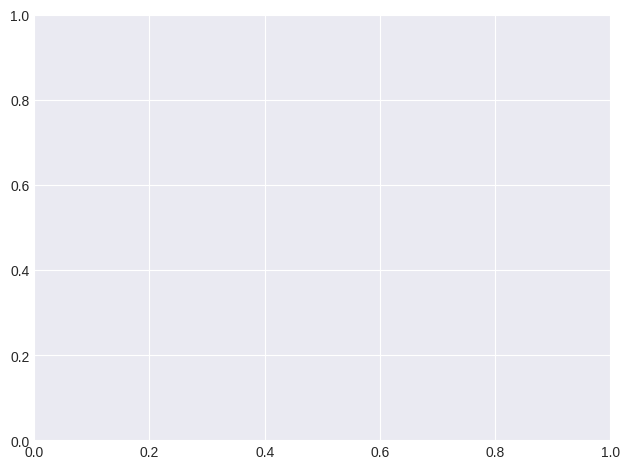

Streaming output truncated to the last 5000 lines.
2025-08-05T18:24:28.965640 - 📈 Predicted: DOWN
2025-08-05T18:24:28.976331 - 📊 Model Evaluation -> Accuracy: 1.00, Precision: 0.00, Recall: 0.00, F1: 0.00
2025-08-05T18:24:28.992459 - Bid: 113655.4 | Ask: 113065.7
2025-08-05T18:24:28.995574 - 📈 Predicted: DOWN
2025-08-05T18:24:29.025451 - 📊 Model Evaluation -> Accuracy: 1.00, Precision: 0.00, Recall: 0.00, F1: 0.00
2025-08-05T18:24:29.030661 - Bid: 113655.4 | Ask: 113065.7
2025-08-05T18:24:29.034597 - 📈 Predicted: DOWN
2025-08-05T18:24:29.046762 - 📊 Model Evaluation -> Accuracy: 1.00, Precision: 0.00, Recall: 0.00, F1: 0.00
2025-08-05T18:24:29.055644 - Bid: 113655.4 | Ask: 113065.7
2025-08-05T18:24:29.058887 - 📈 Predicted: DOWN
2025-08-05T18:24:29.074366 - 📊 Model Evaluation -> Accuracy: 1.00, Precision: 0.00, Recall: 0.00, F1: 0.00
2025-08-05T18:24:29.081210 - Bid: 113655.4 | Ask: 113065.7
2025-08-05T18:24:29.087401 - 📈 Predicted: DOWN
2025-08-05T18:24:29.098913 - 📊 Model Evaluation ->

In [ ]:
import requests
import xgboost as xgb
import websocket
import json
import time
import threading
import ssl
from datetime import datetime, timezone
import joblib
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import deque
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load the trained model
# model = joblib.load("/content/drive/MyDrive/Colab Notebooks/Trade/price_predictor.pkl")


class KuCoinWebSocket:
    def __init__(self):
        self.ws = None
        self.token = None
        self.endpoint = None
        self.keep_running = True
        self.reconnect_delay = 5
        self.ping_interval = 20
        self.last_message_time = time.time()
        self.debug = True
        self.symbol = "BTC-USDT"
        self.orderbook = {"bids": {}, "asks": {}}


        self.plot_data = {
            "timestamps": deque(maxlen=300),
            "mid_prices": deque(maxlen=300),
            "predictions": deque(maxlen=300)
        }

        self.model_path = "/content/drive/MyDrive/Colab Notebooks/Trade/price_predictor.pkl"
        try:
            self.model = joblib.load(self.model_path)
            print("✅ Model loaded.")
        except Exception as e:
            self.model = None
            print(f"❌ Failed to load model: {e}")

        self.model_version = None
        self.model_load_lock = threading.Lock()
        self.last_model_check = 0
        self.model_check_interval = 300  # 5 minutes

        self.load_model()  # Initial load

        # Start model watcher thread
        threading.Thread(target=self.model_watcher, daemon=True).start()

    def load_model(self):
        """Thread-safe model loading with version tracking"""
        with self.model_load_lock:
            try:
                # Check file modification time
                mod_time = os.path.getmtime(self.model_path)

                # Skip if we already have the latest version
                if self.model_version == mod_time and self.model is not None:
                    return True

                # Load the model
                with open(self.model_path, 'rb') as f:
                    self.model = joblib.load(f)

                self.model_version = mod_time
                self.log(f"✅ Model loaded (version: {mod_time})")
                return True

            except FileNotFoundError:
                self.log("⚠️ Model file not found")
            except Exception as e:
                self.log(f"❌ Model load failed: {e}")

            # Fallback: keep existing model if available
            if self.model is None:
                self.log("⚠️ No model available - predictions disabled")
            return False

    def model_watcher(self):
        """Periodically check for model updates"""
        while self.keep_running:
            time.sleep(60)  # Check every minute
            try:
                current_time = time.time()
                if current_time - self.last_model_check > self.model_check_interval:
                    self.last_model_check = current_time
                    self.load_model()
            except Exception as e:
                self.log(f"Model watcher error: {e}")

    def safe_predict(self, model_input):
        """Thread-safe prediction with model validation"""
        if self.model is None:
            if not self.load_model():  # Try to reload
                return None

        try:
            dmatrix = xgb.DMatrix(model_input)
            return self.model.predict(dmatrix)[0]
        except Exception as e:
            self.log(f"Prediction failed: {e}")
            return None


    def log(self, message):
        if self.debug:
            print(f"{datetime.now().isoformat()} - {message}")

    def get_websocket_token(self):
        for attempt in range(3):
            try:
                self.log(f"Fetching new token (attempt {attempt + 1})...")
                url = "https://api.kucoin.com/api/v1/bullet-public"
                response = requests.post(url, timeout=10)
                response.raise_for_status()
                data = response.json()
                if data.get('code') != '200000':
                    raise Exception(f"API Error: {data.get('msg')}")
                self.token = data["data"]["token"]
                self.endpoint = data["data"]["instanceServers"][0]["endpoint"]
                self.log(f"Token received. Endpoint: {self.endpoint}")
                return True
            except Exception as e:
                self.log(f"❌ Attempt {attempt + 1} failed: {e}")
                time.sleep(2)
        return False

    def initialize_orderbook(self):
        try:
            url = f"https://api.kucoin.com/api/v3/market/orderbook/level2?symbol={self.symbol}"
            response = requests.get(url, timeout=10)
            data = response.json()['data']
            self.orderbook['bids'] = {float(price): float(size) for price, size in data['bids']}
            self.orderbook['asks'] = {float(price): float(size) for price, size in data['asks']}
            self.log("Initial order book snapshot loaded")
        except Exception as e:
            self.log(f"Failed to get initial order book: {str(e)}")

    def on_message(self, ws, message):

        self.last_message_time = time.time()
        try:
            data = json.loads(message)

            if data.get("type") == "welcome":
                self.log("Connection acknowledged by server")
                self.initialize_orderbook()
                self.subscribe_orderbook()

            elif data.get("type") == "ack":
                self.log(f"Subscription acknowledged: {data.get('id')}")

            elif data.get("type") == "message":
                if data.get("subject") == "trade.l2update":
                    self.process_orderbook_update(data['data'])
                else:
                    self.log(f"Unhandled message type: {data.get('subject')}")

            elif data.get("type") == "error":
                self.log(f"SERVER ERROR: {data}")

        except Exception as e:
            self.log(f"Message processing error: {str(e)}")

    # def capture_features(self):
    #     best_bid = max(self.orderbook['bids']) if self.orderbook['bids'] else 0
    #     best_ask = min(self.orderbook['asks']) if self.orderbook['asks'] else 0
    #     spread = best_ask - best_bid
    #     mid_price = (best_bid + best_ask) / 2 if best_bid and best_ask else 0
    #     bid_volume = sum(self.orderbook['bids'].values())
    #     ask_volume = sum(self.orderbook['asks'].values())
    #     imbalance = (bid_volume - ask_volume) / (bid_volume + ask_volume) if (bid_volume + ask_volume) != 0 else 0

    #     feature_row = {
    #         'timestamp': datetime.now(timezone.utc).isoformat(),
    #         'best_bid': best_bid,
    #         'best_ask': best_ask,
    #         'spread': spread,
    #         'mid_price': mid_price,
    #         'imbalance': imbalance,
    #         'bid_volume': bid_volume,
    #         'ask_volume': ask_volume
    #     }



    #     model_input = pd.DataFrame([[best_bid, best_ask, spread, mid_price, imbalance, bid_volume, ask_volume]],
    #                               columns=["best_bid", "best_ask", "spread", "mid_price", "imbalance", "bid_volume", "ask_volume"])

    #     try:
    #         prediction = model.predict(model_input)[0]
    #         feature_row['prediction'] = int(prediction)
    #         self.log(f"📈 Predicted price will go: {'UP' if prediction == 1 else 'DOWN'}")
    #     except Exception as e:
    #         self.log(f"❌ Prediction failed: {e}")
    #         feature_row['prediction'] = None

    #     # Append to plot data
    #     self.plot_data["timestamps"].append(datetime.now())
    #     self.plot_data["mid_prices"].append(mid_price)
    #     self.plot_data["predictions"].append(prediction)

    #     return feature_row

    def capture_features(self):

      if not self.orderbook or not isinstance(self.orderbook, dict):
          self.log("⚠️ Orderbook not initialized.")
          return

      try:
          # Extract top-of-book prices
          best_bid = max(self.orderbook["bids"], default=0)
          best_ask = min(self.orderbook["asks"], default=0)

          # Volumes
          bid_volume = sum(self.orderbook["bids"].values())
          ask_volume = sum(self.orderbook["asks"].values())

          # Derived features
          spread = best_ask - best_bid if best_bid and best_ask else 0
          mid_price = (best_bid + best_ask) / 2 if best_bid and best_ask else 0
          imbalance = (bid_volume - ask_volume) / (bid_volume + ask_volume) if (bid_volume + ask_volume) else 0

          # Label
          previous_mid = getattr(self, "last_mid_price", mid_price)
          price_change = mid_price - previous_mid
          actual_label = 1 if price_change > 0 else 0
          self.last_mid_price = mid_price

          # Assemble feature row
          feature_row = {
              "timestamp": datetime.now(timezone.utc).isoformat(),
              "best_bid": best_bid,
              "best_ask": best_ask,
              "spread": spread,
              "mid_price": mid_price,
              "imbalance": imbalance,
              "bid_volume": bid_volume,
              "ask_volume": ask_volume,
              "actual_label": actual_label
          }

          prediction = None  # Safely declare here

          # Prepare model input
          model_input = pd.DataFrame([[best_bid, best_ask, spread, mid_price, imbalance, bid_volume, ask_volume]],
                                    columns=["best_bid", "best_ask", "spread", "mid_price", "imbalance", "bid_volume", "ask_volume"])

          prediction_prob = self.safe_predict(model_input)
          if prediction_prob is not None:
              prediction = int(prediction_prob >= 0.5)
              feature_row["prediction"] = prediction
              self.log(f"📈 Predicted: {'UP' if prediction == 1 else 'DOWN'}")
          else:
              feature_row["prediction"] = None

          # Append for plotting and evaluation
          self.plot_data["timestamps"].append(datetime.now())
          self.plot_data["mid_prices"].append(mid_price)
          self.plot_data["predictions"].append(prediction)
          self.plot_data.setdefault("actuals", deque(maxlen=300)).append(actual_label)

          self.evaluate_predictions()
          return feature_row

      except Exception as e:
          self.log(f"❌ Feature Capture Failed: {e}")
          return None





    def evaluate_predictions(self):
        preds = [p for p in self.plot_data["predictions"] if p is not None]
        actuals = [a for p, a in zip(self.plot_data["predictions"], self.plot_data["actuals"]) if p is not None]


        if len(preds) < 10 or len(preds) != len(actuals):
              return

        acc = accuracy_score(actuals, preds)
        prec = precision_score(actuals, preds, zero_division=0)
        rec = recall_score(actuals, preds, zero_division=0)
        f1 = f1_score(actuals, preds, zero_division=0)

        self.log(f"📊 Model Evaluation -> Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")




    def save_feature_row(self, row):
        file_path = "/content/drive/MyDrive/Colab Notebooks/Trade/features.csv"
        file_exists = os.path.isfile(file_path)

        with open(file_path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=row.keys())

            if not file_exists:
                writer.writeheader()

            writer.writerow(row)  # <-- This must always happen


    def process_orderbook_update(self, update_data):
        changes = update_data['changes']

        if not self.orderbook or "bids" not in self.orderbook or "asks" not in self.orderbook:
          self.log("⚠️ Orderbook not initialized correctly")
          return


        for price, size, _ in changes['asks']:
            price_f = float(price)
            size_f = float(size)
            if size_f == 0:
                self.orderbook['asks'].pop(price_f, None)
            else:
                self.orderbook['asks'][price_f] = size_f

        for price, size, _ in changes['bids']:
            price_f = float(price)
            size_f = float(size)
            if size_f == 0:
                self.orderbook['bids'].pop(price_f, None)
            else:
                self.orderbook['bids'][price_f] = size_f

        best_bid = max(self.orderbook['bids'].keys()) if self.orderbook['bids'] else 0
        best_ask = min(self.orderbook['asks'].keys()) if self.orderbook['asks'] else 0

        self.log(f"Bid: {best_bid} | Ask: {best_ask}")
        feature_row = self.capture_features()
        self.save_feature_row(feature_row)

    def on_error(self, ws, error):
        self.log(f"WebSocket Error: {error}")
        self.schedule_reconnect()

    def on_close(self, ws, close_status_code, close_msg):
        self.log(f"Closed (Code: {close_status_code}, Reason: {close_msg})")
        self.schedule_reconnect()

    def on_open(self, ws):
        self.log("WebSocket Connected")

    def subscribe_orderbook(self):
        sub_msg = {
            "id": int(time.time() * 1000),
            "type": "subscribe",
            "topic": f"/market/level2:{self.symbol}",
            "privateChannel": False,
            "response": True
        }
        self.ws.send(json.dumps(sub_msg))
        self.log(f"Subscribed to {self.symbol} orderbook")

    def start_ping(self):
        while self.keep_running:
            if time.time() - self.last_message_time > self.ping_interval:
                if self.ws and hasattr(self.ws, 'sock') and self.ws.sock and self.ws.sock.connected:
                    try:
                        self.ws.send(json.dumps({"id": str(int(time.time())), "type": "ping"}))
                        self.log("Sent ping")
                    except Exception as e:
                        self.log(f"Ping failed: {str(e)}")
                        self.schedule_reconnect()
                        break
            time.sleep(1)

    def schedule_reconnect(self):
        if not self.keep_running:
            return
        self.log(f"Reconnecting in {self.reconnect_delay} sec...")
        time.sleep(self.reconnect_delay)
        self.connect()

    def connect(self):
        self.keep_running = False
        time.sleep(1)
        self.keep_running = True

        self.log("🔄 Starting connection...")

        if not self.get_websocket_token():
            self.log("❌ Token fetch failed during reconnect.")
            self.schedule_reconnect()
            return

        ws_url = f"{self.endpoint}?token={self.token}&connectId={int(time.time())}"
        self.log(f"Connecting to: {ws_url}")

        self.ws = websocket.WebSocketApp(
            ws_url,
            on_open=self.on_open,
            on_message=self.on_message,
            on_error=self.on_error,
            on_close=self.on_close
        )

        threading.Thread(target=self.start_ping, daemon=True).start()

        try:
            self.ws.run_forever(
                sslopt={"cert_reqs": ssl.CERT_NONE},
                ping_interval=15,
                ping_timeout=10
            )
        except Exception as e:
            self.log(f"❌ run_forever failed: {e}")
            self.schedule_reconnect()

    def run(self):
        threading.Thread(target=self.start_plotting, daemon=True).start()
        self.connect()

    def stop(self):
        self.keep_running = False
        if self.ws:
            self.ws.close()
        self.log("WebSocket client stopped")


    def init_plot_data(self):
        self.max_len = 100
        self.plot_data = {
            "timestamps": deque(maxlen=self.max_len),
            "mid_prices": deque(maxlen=self.max_len),
            "predictions": deque(maxlen=self.max_len)
        }

    def start_plotting(self):
        plt.style.use("seaborn-v0_8-darkgrid")
        self.fig, self.ax = plt.subplots()

        def update(frame):
            if not self.plot_data["timestamps"]:
                return

            times = list(self.plot_data["timestamps"])
            mids = list(self.plot_data["mid_prices"])
            preds = list(self.plot_data["predictions"])

            self.ax.clear()
            self.ax.plot(times, mids, label="Mid Price", color="blue")

            self.ax.scatter(
                [t for t, p in zip(times, preds) if p == 1],
                [m for m, p in zip(mids, preds) if p == 1],
                color="green", label="Prediction: UP", marker="^"
            )
            self.ax.scatter(
                [t for t, p in zip(times, preds) if p == 0],
                [m for m, p in zip(mids, preds) if p == 0],
                color="red", label="Prediction: DOWN", marker="v"
            )

            self.ax.set_title("Live BTC-USDT Mid Price & Prediction")
            self.ax.set_ylabel("Mid Price (USDT)")
            self.ax.set_xlabel("Time")
            self.ax.legend(loc="upper left")
            self.fig.autofmt_xdate()

        self.ani = FuncAnimation(self.fig, update, interval=1000)
        plt.tight_layout()
        plt.show()




if __name__ == "__main__":
    while True:
        try:
            client = KuCoinWebSocket()
            client.run()
        except KeyboardInterrupt:
            print("🛑 Manually stopped.")
            try:
                client.stop()
            except:
                pass
            break
        except Exception as e:
            print(f"❌ Fatal Error: {e}. Restarting in 10s...")
            try:
                client.stop()
            except:
                pass
            time.sleep(10)
